# Importing libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Creating Virtual Environment
# !pip install virtualenv
# !virtualenv /content/drive/MyDrive/MedImEnv

In [ ]:
# Activating Env and installing libraries
# !source /content/drive/MyDrive/MedImEnv/bin/activate; python -m pip install pyradiomics #; python -m pip install nibabel; python -m pip install pydicom;

In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/MedImEnv/lib/python3.10/site-packages")

In [ ]:
from pydicom import dcmread
import pydicom.errors
# from radiomics import featureextractor
# import nibabel as nib

# General
import os # tools to deal with paths
import glob #find files recursively
import logging
import numpy as np  # matrix manipulation
import matplotlib.pyplot as plt # plotting
import pandas as pd # DB

from tqdm import tqdm
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout,Input,Conv2D, Activation, BatchNormalization, MaxPooling2D, concatenate, Conv2DTranspose, UpSampling2D, SeparableConv2D
from tensorflow.keras.layers import ZeroPadding2D,Add,ReLU,AveragePooling2D
from tensorflow.keras import metrics as mtt
from tensorflow.keras import optimizers

from sklearn.model_selection import train_test_split

# Importing Data

Setting directories to access data in the drive folder

In [ ]:
# base_path = '/content/drive/MyDrive/Medical Imaging/Project/' # Unimib Account
base_path = '/content/drive/MyDrive/Project/' # Personal Account
subfolder_train = 'Data/train/'
subfolder_test = 'Data/test/'
subfolder_db = 'Data/train-rle.csv'
subfolder_fullds = 'Data/Pneumothorax_full/dicom_files/'

Reading the '`.csv`' file containing the patients code and the pixel encoding for the masks

In [ ]:
mask_df = pd.read_csv(base_path + 'Data/train-rle.csv')
mask_df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002...
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...


In [ ]:
mask_df.columns

Index(['ImageId', ' EncodedPixels'], dtype='object')

Rename the column `' EncodedPixels'` deleting the space at the beginning


In [ ]:
mask_df.rename(columns={' EncodedPixels': 'EncodedPixels'}, inplace=True)

Generate a list of all files in the full dataset

In [ ]:
f_list_full = glob.glob(base_path + subfolder_fullds + '*')
len(f_list_full)

10719

In [ ]:
f_list_full[:5]

['/content/drive/MyDrive/Project/Data/Pneumothorax_full/dicom_files/1.2.276.0.7230010.3.1.4.8323329.4877.1517875185.209833.dcm',
 '/content/drive/MyDrive/Project/Data/Pneumothorax_full/dicom_files/1.2.276.0.7230010.3.1.4.8323329.4872.1517875185.186603.dcm',
 '/content/drive/MyDrive/Project/Data/Pneumothorax_full/dicom_files/1.2.276.0.7230010.3.1.4.8323329.4864.1517875185.165826.dcm',
 '/content/drive/MyDrive/Project/Data/Pneumothorax_full/dicom_files/1.2.276.0.7230010.3.1.4.8323329.4862.1517875185.159443.dcm',
 '/content/drive/MyDrive/Project/Data/Pneumothorax_full/dicom_files/1.2.276.0.7230010.3.1.4.8323329.4860.1517875185.145872.dcm']

## 1$^{st}$ patient data

`.dcm` files can be read using `pydicom.dcmread`. We read the first file in the list:

In [ ]:
fp_file = dcmread(f_list_full[0])
fp_file

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.4877.1517875185.209833
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.4877.1517875185.209833
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

Data are stored as Dataset, you can access specific elements by their DICOM keyword or tag number. In this case we are interested in **Pixel Data**, so we use the method `.pixel_array` to access them:

In [ ]:
fp_img = fp_file.pixel_array
print(f"'fp_img' Data type:\t{type(fp_img)}")
print(f"'fp_img' shape:\t\t{fp_img.shape}")

'fp_img' Data type:	<class 'numpy.ndarray'>
'fp_img' shape:		(1024, 1024)


We can also access other informations, like **Age** or **Gender**

In [ ]:
# Age
fp_age = fp_file.PatientAge
print(f"First Patient Age: {fp_age}\tData type: {type(fp_age)}")
fp_age = int(fp_age) # Converting to integer
print(f"First Patient Age: {fp_age}\tData type: {type(fp_age)}")

# Gender
fp_gend = fp_file.PatientSex
print(f"\nFirst Patient Gender: {fp_gend}\tData type: {type(fp_gend)}")

First Patient Age: 58	Data type: <class 'str'>
First Patient Age: 58	Data type: <class 'int'>

First Patient Gender: F	Data type: <class 'str'>


Showing the image of the first patient:

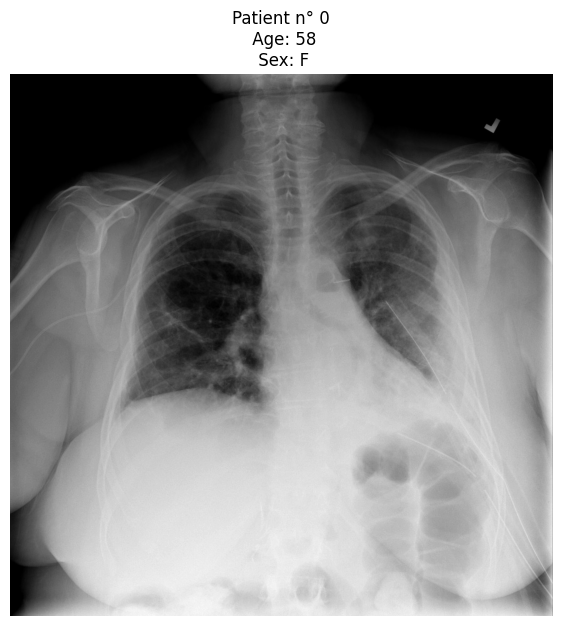

In [ ]:
plt.figure(figsize=(7,9))
plt.imshow(fp_img, cmap='gray')
plt.title(f'Patient n° {0}\n Age: {fp_age}\n Sex: {fp_gend}')
plt.axis('off')
plt.show()

## Loading and Preprocessing functions definition

In [ ]:
def dataloader(file_list, output_shape, mask_df):

    # Configure logging
    log_file = base_path + 'files/dataloader.log'
    logging.basicConfig(filename=log_file, level=logging.INFO,
                        format='%(asctime)s - %(levelname)s - %(message)s')

    # Calculating the number of patients
    n_pat = len(file_list)

    # Initialize four NumPy arrays with zeros
    immV = np.zeros((n_pat, *output_shape,1), dtype=np.float32)    # Images array
    segV = np.zeros((n_pat, *output_shape,1), dtype=np.float32)    # Segmentation Mask array
    ageV = np.zeros((n_pat, 1), dtype=np.float32)    # Ages array
    gendV = np.zeros((n_pat,1), dtype=np.float32)    # Genders array

    for i,f in tqdm(enumerate(file_list)):
        if os.path.isfile(f) and f.lower().endswith('.dcm'):
            try:
                # Attempt to read the DICOM file
                ds = dcmread(f)    # 'dicom' file containing patient data
                filename = os.path.basename(f)[:-4]        # Without '.dcm' extension

                # Image
                temp_img = ds.pixel_array        # Image for the current patient
                t_shape = temp_img.shape         # Evaluate the shape of the image, should be (1024,1024)
                if t_shape != output_shape:
                    temp_img = resize_img(temp_img, output_shape)    # Calling the function to resize the image
                temp_img = temp_img.astype('float32') / 255.0    # Normalizing pixel values from (0,255) to (0,1)
                immV[i,:,:,0] = temp_img        # Assign the current image to the position 'i' in 'immV'

                # Mask
                patient_index = mask_df[mask_df['ImageId']==filename] # Searching for the correspondent patient_index in the 'mask_df'
                if len(patient_index) == 0:    # Log the message if the patient is not present in 'mask_df'
                    logging.info(f"Patient n°{i}, {filename} not found in mask_df. Assuming patient is healthy.")
                else:
                    patient_index = patient_index.index[0]   # Extract the row index
                    EncodedPixels = mask_df['EncodedPixels'].iloc[patient_index]   # Extract the Run Length Encoding (RLE) of the segmentation mask
                    temp_mask = create_mask(EncodedPixels, t_shape)   # Pass the RLE and the shape of the image to the 'create_mask' function
                    if t_shape != output_shape:
                        temp_mask = resize_img(temp_mask, output_shape)   # Calling the function to resize the mask
                        temp_mask = (temp_mask >= 0.5).astype(np.float32)    # Convert elements to binary representation
                    segV[i,:,:,0] = temp_mask    # Assign the current mask to the position 'i' in 'segV'

                #Age
                ageV[i,0] = int(ds.PatientAge)        # Assign patient age to the position 'i' in 'ageV'

                # Gender
                temp_sex = ds.PatientSex    # Extract current patient gender
                if temp_sex == 'F':     # Map 'F'->1 and 'M'->0
                    gendV[i,0] = 1      # Assign patient gender to the position 'i' in 'gendV' in categorical d
                else:
                    gendV[i,0] = 0


            except Exception as e:
                # Log the error message
                logging.error(f"Error reading {f}: {e}")

    return immV, segV, ageV, gendV

In [ ]:
def create_mask(EncodedPixels, im_shape):
    rel = convert_into_integer(EncodedPixels)    # Call the function to convert 'EncodedPixels' string into integers
    im_size = im_shape[0] * im_shape[1]    # Define the (flattened) shape of the mask
    mask = np.zeros(im_size)    # Initialize a NumPy array with zeros of shape 'im_size'

    # RLE decoding
    current_pixel = 0
    if rel != -1:    # Check if 'rle' is not -1 (-1 means healthy patient -> empty mask)
        for i in range(0, len(rel), 2):
            if current_pixel == 0:    # First pair, take the start position directly from 'rel[i]'
                start_pixel = rel[i]
            else:    # Following pairs, add the relative position to the current pixel position
                start_pixel = current_pixel + rel[i]
            stop_pixel = start_pixel + rel[i+1]    # Update stop position and current position
            current_pixel = stop_pixel
            mask[start_pixel:stop_pixel] = 1    # Set the mask value to 1 from 'start_pixel' to 'stop_pixel'

    # Reshape the 1D mask to a 2D mask
    mask = mask.reshape(-1, int(np.sqrt(mask.shape)[0]))
    mask = np.transpose(mask)
    return mask

In [ ]:
def convert_into_integer(stringa):
  stringa = stringa.strip()
  if stringa == '-1':
    return -1
  else:
    return list(map(int, stringa.split()))

In [ ]:
def resize_img(img, output_shape):
    input_shape = img.shape
    img = np.reshape(img, (output_shape[0], int(input_shape[0]/output_shape[0]), output_shape[1], int(input_shape[1]/output_shape[1]) )) # Reshape the image into e.g. (512,2,512,2)
    img = np.mean(np.mean(img, axis=-1), axis=1)        # Averaging to get e.g. (512,512) image
    return img

## Data Loading

Due to limited computational resources we had to run the `dataloader()` function locally and split the dataset into two halves. The dataloader creates a `.log` file called `dataloader.log` that records eventual warning and errors occurred during process.

After that we saved the processed variables as 'pickle' files into the drive folder "Data", so that the operation does not have to be re-executed each time the runtime is restarted.

Images will be resized from (1024,1024) to (256,256) for the same reasons.



In [ ]:
# immV1, segV1, ageV1, gendV1 = dataloader(f_list_full[:5000], (256,256), mask_df)

In [ ]:
# with open(base_path + 'files/immV1.pkl', 'wb') as f:
#     pickle.dump(immV1, f)
# with open(base_path + 'files/segV1.pkl', 'wb') as f:
#     pickle.dump(segV1, f)
# with open(base_path + 'files/ageV1.pkl', 'wb') as f:
#     pickle.dump(ageV1, f)
# with open(base_path + 'files/gendV1.pkl', 'wb') as f:
#     pickle.dump(gendV1, f)

In [ ]:
# immV2, segV2, ageV2, gendV2 = dataloader(f_list_full[5000:], (256,256), mask_df)

In [ ]:
# with open(base_path + 'files/immV2.pkl', 'wb') as f:
#     pickle.dump(immV2, f)
# with open(base_path + 'files/segV2.pkl', 'wb') as f:
#     pickle.dump(segV2, f)
# with open(base_path + 'files/ageV2.pkl', 'wb') as f:
#     pickle.dump(ageV2, f)
# with open(base_path + 'files/gendV2.pkl', 'wb') as f:
#     pickle.dump(gendV2, f)

Display the `dataloader.log` file:

In [ ]:
with open(base_path + 'files/dataloader.log', 'r', encoding='latin-1') as file:
    print(file.read())

2024-05-22 17:15:28,134 - INFO - Patient n°252, 1.2.276.0.7230010.3.1.4.8323329.10231.1517875222.737143 not found in mask_df. Assuming patient is healthy.
2024-05-22 17:15:31,144 - INFO - Patient n°396, 1.2.276.0.7230010.3.1.4.8323329.10362.1517875223.377845 not found in mask_df. Assuming patient is healthy.
2024-05-22 17:15:32,179 - INFO - Patient n°445, 1.2.276.0.7230010.3.1.4.8323329.10407.1517875223.567351 not found in mask_df. Assuming patient is healthy.
2024-05-22 17:15:36,667 - INFO - Patient n°654, 1.2.276.0.7230010.3.1.4.8323329.10599.1517875224.488727 not found in mask_df. Assuming patient is healthy.
2024-05-22 17:15:38,485 - INFO - Patient n°743, 1.2.276.0.7230010.3.1.4.8323329.1068.1517875166.144255 not found in mask_df. Assuming patient is healthy.
2024-05-22 17:15:48,305 - INFO - Patient n°1208, 1.2.276.0.7230010.3.1.4.8323329.11104.1517875231.169401 not found in mask_df. Assuming patient is healthy.
2024-05-22 17:15:50,775 - INFO - Patient n°1328, 1.2.276.0.7230010.3.1

Always due to limited computational resources we will use just the first half of the dataset

In [ ]:
file_paths = [
    base_path + 'files/immV1.pkl',
    base_path + 'files/segV1.pkl',
    base_path + 'files/ageV1.pkl',
    base_path + 'files/gendV1.pkl',
    # base_path + 'files/immV2.pkl',
    # base_path + 'files/segV2.pkl',
    # base_path + 'files/ageV2.pkl',
    # base_path + 'files/gendV2.pkl',
]

for file_path in file_paths:
    with open(file_path, 'rb') as f:
        if 'immV1' in file_path:
            immV1 = pickle.load(f)
        elif 'segV1' in file_path:
            segV1 = pickle.load(f)
        elif 'ageV1' in file_path:
            ageV1 = pickle.load(f)
        elif 'gendV1' in file_path:
            gendV1 = pickle.load(f)
        elif 'immV2' in file_path:
            immV2 = pickle.load(f)
        elif 'segV2' in file_path:
            segV2 = pickle.load(f)
        elif 'ageV2' in file_path:
            ageV2 = pickle.load(f)
        elif 'gendV2' in file_path:
            gendV2 = pickle.load(f)

In [ ]:
print(f"immV1 shape: \t{immV1.shape}")
print(f"segV1 shape: \t{segV1.shape}")
print(f"ageV1 shape: \t{ageV1.shape}")
print(f"gendV1 shape: \t{gendV1.shape}")

immV1 shape: 	(5000, 256, 256, 1)
segV1 shape: 	(5000, 256, 256, 1)
ageV1 shape: 	(5000, 1)
gendV1 shape: 	(5000, 1)


# Data Exploration

We depict some visualization to have a better idea of the distributions of the considered variables.

## Age Distribution

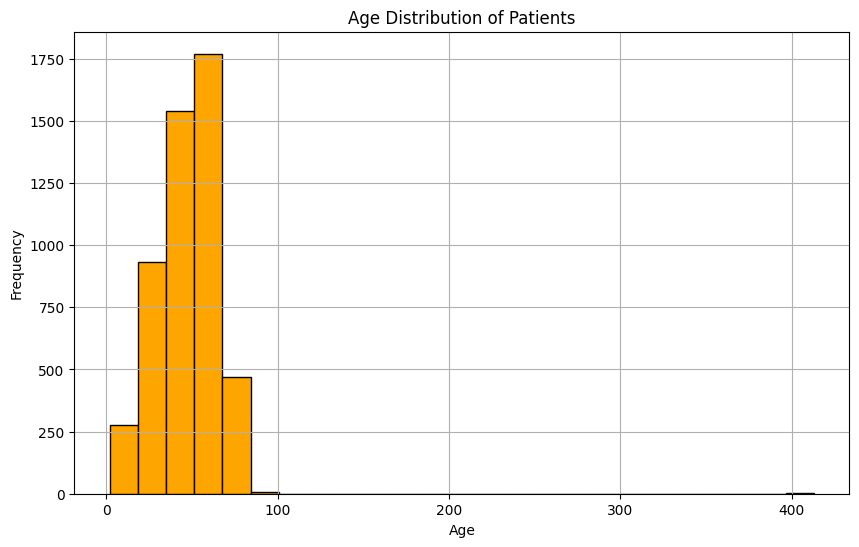

In [ ]:
# Plotting the histogram
plt.figure(figsize=(10, 6))  # Adjust the figure size
plt.hist(ageV1, bins=25, color='orange', edgecolor='black')  # Adjust the number of bins
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

It seems that in the dataset there is a patient with age near to 400, probably due to a typo. We search for it and remove it from the visualization.

In [ ]:
np.where(ageV1[:,0]>130)[0][0]

1210

In [ ]:
ageV1[1210][0]

413.0

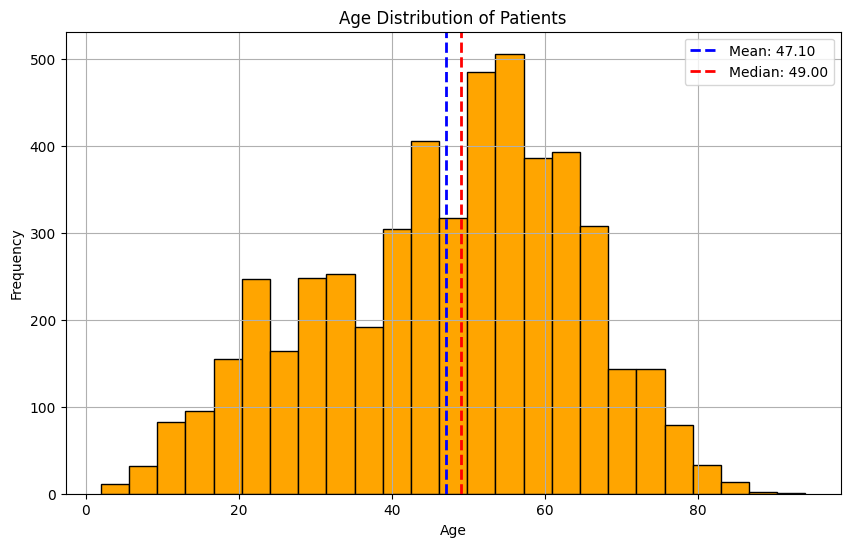

In [ ]:
# Plotting the histogram
plt.figure(figsize=(10, 6))  # Adjust the figure size
plt.hist(np.delete(ageV1, 1210), bins=25, color='orange', edgecolor='black')  # Adjust the number of bins
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)


# Plot the mean
plt.axvline(np.mean(np.delete(ageV1, 1210)), color='blue', linestyle='dashed', linewidth=2, label=f'Mean: {np.mean(np.delete(ageV1, 1210)):.2f}')

# Plot the median
plt.axvline(np.median(np.delete(ageV1, 1210)), color='red', linestyle='dashed', linewidth=2, label=f'Median: {np.median(np.delete(ageV1, 1210)):.2f}')

# Add labels and legend
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution of Patients')
plt.grid(True)
plt.legend()
plt.show()

## Gender Distribution

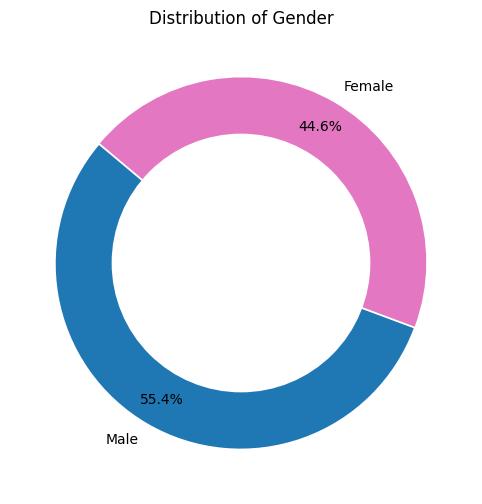

In [ ]:
# Calculate the unique values and their counts
unique, counts = np.unique(gendV1, return_counts=True)
gender_counts = dict(zip(unique, counts))

# Prepare data for the pie chart
labels = ['Male', 'Female']
sizes = [gender_counts.get(0, 0), gender_counts.get(1, 0)]  # Get counts, default to 0 if key doesn't exist
colors = ['tab:blue', 'tab:pink']

# Plotting the pie chart
plt.figure(figsize=(8, 6))  # Adjust the figure size
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', pctdistance=0.85, startangle=140, explode=(0.005, 0.005))

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()

# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)

plt.title('Distribution of Gender')
plt.show()

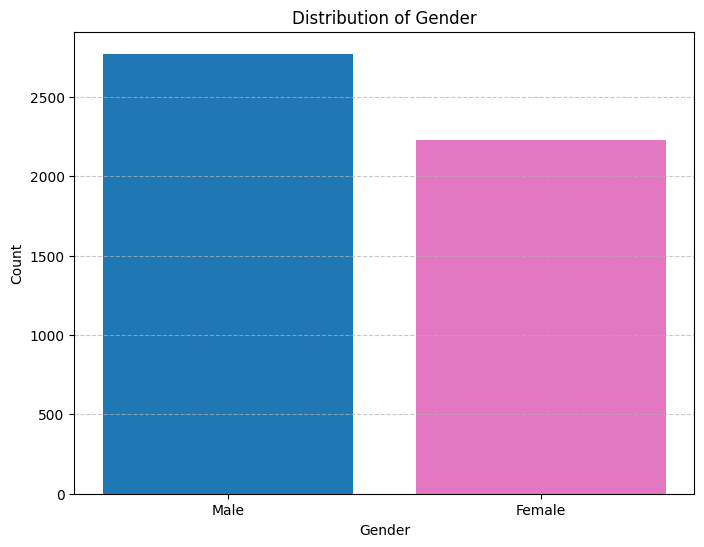

In [ ]:
unique, counts = np.unique(gendV1, return_counts=True)
gender_counts = dict(zip(unique, counts))

# Plotting the bar plot
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.bar(gender_counts.keys(), gender_counts.values(), color=['tab:blue', 'tab:pink'])
plt.xticks([0, 1], ['Male', 'Female'])
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Healthy-Unhealthy distribution

First we calculate the number of healthy and unhealthy patients. A patient is considered healthy if its segmentation mask is empty, i.e. the sum of pixel values is 0, otherwise he will be considered unhealthy.

In [ ]:
pixel_sums = np.sum(segV1, axis=(1, 2, 3))    # Sum pixels in each segmentation mask
healthy_patients = np.where(pixel_sums == 0)[0]    # Get the indeces of healthy patients
unhealthy_patients = np.where(pixel_sums > 0)[0]    # Get the indeces of unhealthy patients
print(f"Number of healthy patients: {len(healthy_patients)}")
print(f"Number of unhealthy patients: {len(unhealthy_patients)}")

Number of healthy patients: 3893
Number of unhealthy patients: 1107


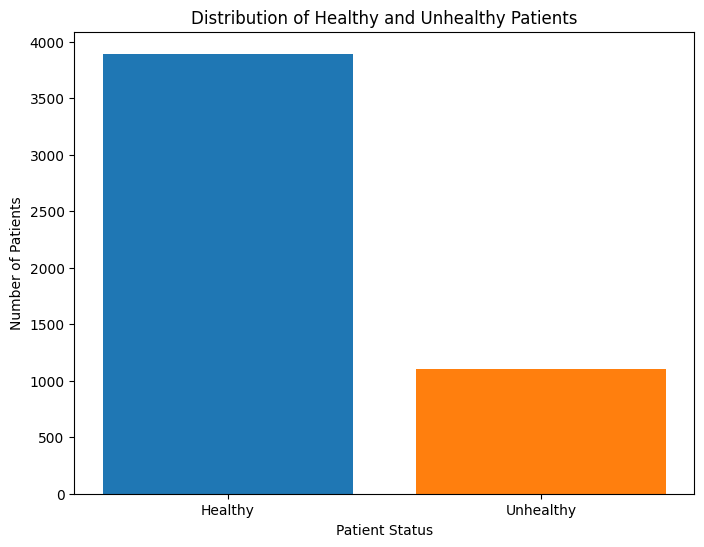

In [ ]:
labels = ['Healthy', 'Unhealthy']
counts = [len(healthy_patients), len(unhealthy_patients)]

plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['tab:blue', 'tab:orange'])
plt.xlabel('Patient Status')
plt.ylabel('Number of Patients')
plt.title('Distribution of Healthy and Unhealthy Patients')
plt.show()

## Mask representation

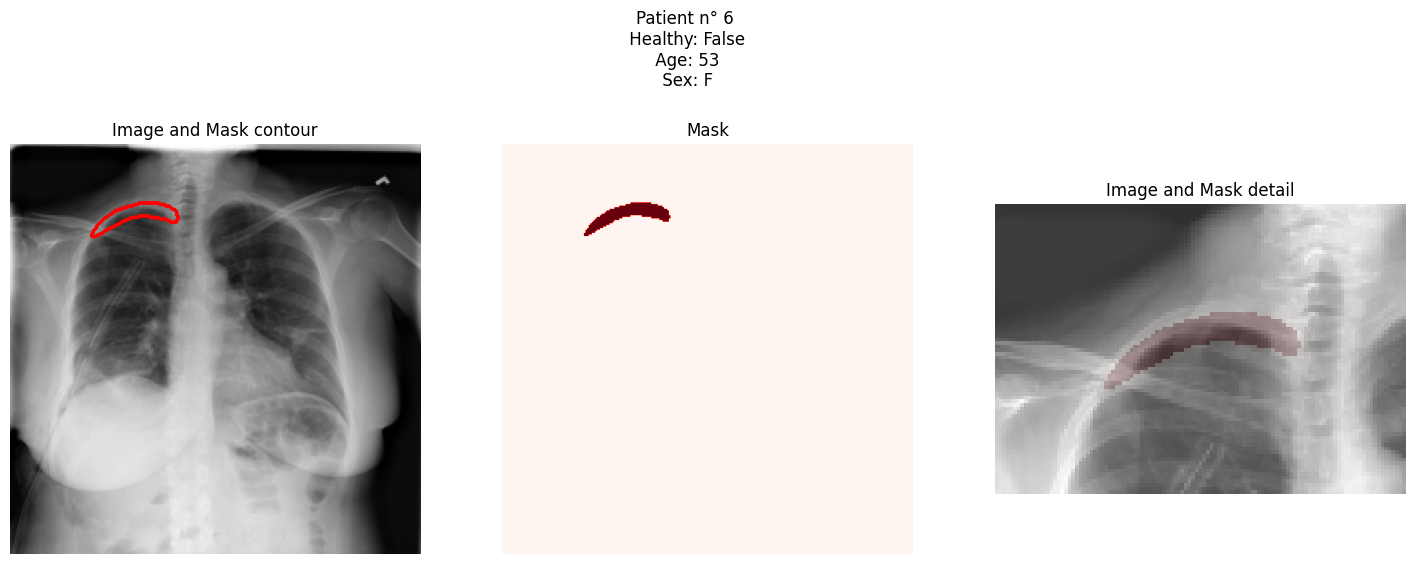

In [ ]:
# # Select a patient
patient_number = 6

image = immV1[patient_number,:,:,0]
mask = segV1[patient_number,:,:,0]
if np.sum(mask)==0:
    healthy = True
else:
    healthy = False

g_map = {0: 'M', 1: 'F'}
gender = g_map[gendV1[patient_number][0]]
age = ageV1[patient_number][0]

fig, ax = plt.subplots(1,3, figsize=(18,7))
plt.suptitle(f'Patient n° {patient_number}\n Healthy: {healthy}\n Age: {int(age)}\n Sex: {gender}')
ax[0].imshow(image, cmap='gray')#, vmin=20, vmax=200)
ax[0].axis('off')
ax[0].contour(mask, colors='red')
ax[0].set_title('Image and Mask contour')

ax[1].imshow(mask, cmap='Reds')
ax[1].axis('off')
ax[1].set_title('Mask')

nonzero_indices = np.nonzero(mask)
if np.sum(nonzero_indices) == 0:
    min_x, max_x = 0,len(image)-1
    min_y, max_y = 0,len(image)-1
else:
    min_x, max_x = max([min(nonzero_indices[1])-30, 0]), min([max(nonzero_indices[1])+30, image.shape[1]])
    min_y, max_y = max([min(nonzero_indices[0])-30, 0]), min([max(nonzero_indices[0])+30, image.shape[0]])

ax[2].imshow(image[min_y:max_y,min_x:max_x], cmap='gray')#, vmin=20, vmax=200)
ax[2].imshow(mask[min_y:max_y,min_x:max_x], cmap='Reds', alpha=0.2)
ax[2].axis('off')
ax[2].set_title('Image and Mask detail')
plt.show()